In [76]:
# Initial imports
import os
import sys
import requests
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame
from MCForecastTools import MCSimulation
import matplotlib.pyplot as plt


%matplotlib inline

In [77]:
# Load .env enviroment variables
load_dotenv('api.env')

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [78]:
# Set current amount of crypto assets
BTC_holdings = 1.2
ETH_holdings = 5.3

In [79]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [80]:
# Fetch current BTC price
btc_response = requests.get(btc_url)

# Fetch current ETH price
eth_response = requests.get(eth_url)

if btc_response.status_code == 200 and eth_response.status_code == 200:
    # Parse the JSON responses
    btc_data = btc_response.json()
    eth_data = eth_response.json()
    
    btc_price_usd = btc_data['data']['1']['quotes']['USD']['price']
    eth_price_usd = eth_data['data']['1027']['quotes']['USD']['price']
else:
    raise Exception("Error fetching cryptocurrency prices")
    
# Compute current value of my crpto
total_btc_value = BTC_holdings * btc_price_usd
total_eth_value = ETH_holdings * eth_price_usd
total_wallet_value = total_btc_value + total_eth_value

# Print current crypto wallet balance
print(f"The current value of your {BTC_holdings} BTC is ${total_btc_value:0.2f}")
print(f"The current value of your {ETH_holdings} ETH is ${total_eth_value:0.2f}")
print(f"The total value of your cryptocurrency wallet is ${total_wallet_value:0.2f}")

The current value of your 1.2 BTC is $83607.60
The current value of your 5.3 ETH is $19606.77
The total value of your cryptocurrency wallet is $103214.37


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [81]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [82]:
# Set Alpaca API key and secret
alpaca_api_key= os.getenv("ALPACA_API_KEY")
alpaca_secret_key= os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [83]:
print(f"Alpaca Key Type:{type(alpaca_api_key)}")
print(f"Alpaca Key Type:{type(alpaca_secret_key)}")

Alpaca Key Type:<class 'str'>
Alpaca Key Type:<class 'str'>


In [84]:
# Set the tickers
tickers = ["AGG", "SPY"]

In [85]:
# Set timeframe to "1Day" for Alpaca API
timeframe = TimeFrame.Day

In [86]:
# Pick AGG and SPY close prices
current_date = pd.Timestamp.now(tz='America/New_York').isoformat()

start_date = pd.Timestamp('2020-08-07', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2020-08-07', tz='America/New_York').isoformat()
df = alpaca.get_bars(tickers, timeframe, start=start_date, end=end_date).df

# Reset the index to make 'timestamp' a column
df = df.reset_index()

# Reorganize the DataFrame
df = df.pivot(index='timestamp', columns='symbol', values='close')

# Extract AGG and SPY close prices
agg_close_price = df['AGG'][0]
spy_close_price = df['SPY'][0]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $119.43
Current SPY closing price: $334.57


C:\Users\jiv50\AppData\Local\Temp\ipykernel_21896\16431007.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  agg_close_price = df['AGG'][0]
C:\Users\jiv50\AppData\Local\Temp\ipykernel_21896\16431007.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spy_close_price = df['SPY'][0]


In [87]:
# Compute the current value of shares
total_agg_value = my_agg * agg_close_price
total_spy_value = my_spy * spy_close_price
total_stocks_bonds_value = total_agg_value + total_spy_value

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${total_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${total_agg_value:0.2f}")
print(f"The total value of your stock and bond portfolio is ${total_stocks_bonds_value:0.2f}")

The current value of your 50 SPY shares is $16728.50
The current value of your 200 AGG shares is $23886.00
The total value of your stock and bond portfolio is $40614.50


### Savings Health Analysis

In [88]:
# Set monthly household income
monthly_income = 12000 

# Consolidate financial assets data
savings_data = [total_wallet_value, total_stocks_bonds_value]
columns = ["amount"]
index = ["crypto", "stock/bond"]

# Create savings DataFrame
savings_df = pd.DataFrame(savings_data, index=index, columns=columns)

# Display savings DataFrame
print(savings_df)


                amount
crypto      103214.367
stock/bond   40614.500


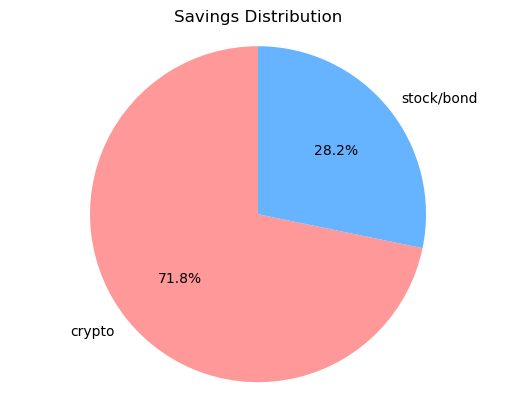

In [89]:
# Plot savings pie chart
labels = savings_df.index
sizes = savings_df['amount']
colors = ['#ff9999', '#66b3ff']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.title('Savings Distribution')
plt.show()

In [90]:
# Set ideal emergency fund
emergency_fund_value = monthly_income * 3

# Calculate total amount of savings
total_savings = savings_df['amount'].sum()

# Validate saving health
if total_savings > emergency_fund_value:
    print("Yay! You have enough money in your emergency fund.")
elif total_savings == emergency_fund_value:
    print("Congratulations! You have reached your emergency fund goal.")
else:
    print(f"You need to save more. Your emergency fund is short by ${emergency_fund_value - total_savings:,.2f}.")

Yay! You have enough money in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [114]:
# Set start and end dates of five years back from today.
start_date = pd.Timestamp('2019-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2024-05-01', tz='America/New_York').isoformat()


print(f"Start date: {start_date}")
print(f"End date: {end_date}")

Start date: 2019-05-01T00:00:00-04:00
End date: 2024-05-01T00:00:00-04:00


In [117]:
# Get 5 years' worth of historical data for SPY and AGG
df_ticker= alpaca.get_bars(tickers, TimeFrame.Day, start=start_date, end=end_date).df

# Reorganize the DataFrame
historical_bars_pivot = historical_bars.pivot(index='timestamp', columns='symbol', values='close')

# Separate ticker data
agg_df = historical_bars_pivot['AGG'].to_frame().rename(columns={'AGG': 'AGG_close'})
spy_df = historical_bars_pivot['SPY'].to_frame().rename(columns={'SPY': 'SPY_close'})

# Concatenate the ticker DataFrames
df_stock_data = pd.concat([agg_df, spy_df], axis=1, join='inner')

# Display sample data
print(df_stock_data.head())
df_ticker.head()

                           AGG_close  SPY_close
timestamp                                      
2019-05-01 04:00:00+00:00     108.40     291.82
2019-05-02 04:00:00+00:00     108.16     291.13
2019-05-03 04:00:00+00:00     108.34     293.98
2019-05-06 04:00:00+00:00     108.48     292.83
2019-05-07 04:00:00+00:00     108.61     288.05


,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2019-05-01 04:00:00+00:00,108.40,108.76,108.320,23490,108.47,7722131,108.446022,AGG
2019-05-02 04:00:00+00:00,108.16,108.33,108.100,10084,108.33,4546021,108.169368,AGG
2019-05-03 04:00:00+00:00,108.34,108.42,108.275,11700,108.32,2454806,108.330008,AGG
2019-05-06 04:00:00+00:00,108.48,108.57,108.440,9829,108.56,4778473,108.483855,AGG
2019-05-07 04:00:00+00:00,108.61,108.70,108.585,11537,108.63,3344596,108.642362,AGG


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 110.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 120.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 130.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 140.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 150.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 160.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 170.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 180.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 190.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 200.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 210.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 220.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 230.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 240.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 250.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 260.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 270.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 280.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 290.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 300.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 310.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 320.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 330.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 340.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 350.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 360.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 370.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 380.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 390.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 400.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 410.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 420.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 430.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 440.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 450.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 460.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 470.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 480.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 490.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

ValueError: autodetected range of [-inf, inf] is not finite

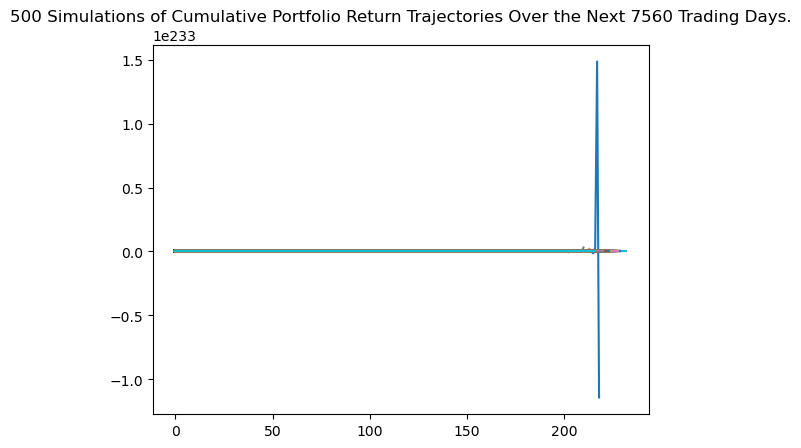

In [128]:
# Add the directory containing MCForecastTools.py to the Python path
sys.path.append(r'C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code')
from MCForecastTools import MCSimulation

# Create an example DataFrame with historical prices
dates = pd.date_range(start='2019-05-01', periods=100, freq='D')
data = np.random.rand(100, 2)
historical_bars_pivot = pd.DataFrame(data, columns=['A', 'B'], index=dates)

# Add a level to the columns
historical_bars_pivot.columns = pd.MultiIndex.from_product([historical_bars_pivot.columns, ['close']])

# Calculate daily returns
close_df = historical_bars_pivot.xs('close', level=1, axis=1).pct_change().dropna()
daily_return = close_df.copy()
daily_return.columns = pd.MultiIndex.from_product([daily_return.columns, ['daily_return']])

# Combine the data
historical_bars_pivot = pd.concat([historical_bars_pivot, daily_return], axis=1)

# Parameters
num_simulations = 500
num_trading_days = 252 * 30

# Create an instance of the MCSimulation class
mc_sim_thirtyyear = MCSimulation(
    portfolio_data=historical_bars_pivot,
    weights=[0.6, 0.4],
    num_simulation=num_simulations,
    num_trading_days=num_trading_days
)

# Run the Monte Carlo simulation
mc_sim_thirtyyear.calc_cumulative_return()

# Plot the results
line_plot = mc_sim_thirtyyear.plot_simulation()
line_plot.figure.show()

# Plot the probability distribution and confidence intervals
dist_plot = mc_sim_thirtyyear.plot_distribution()
dist_plot.show()

# Summarize the results
summary = mc_sim_thirtyyear.summarize_cumulative_return()
print(summary)


In [141]:
# Printing the simulation input data
print("Simulation Input Data:")
print(df_stock_data.describe())

Simulation Input Data:
         AGG_close    SPY_close
count  1260.000000  1260.000000
mean    107.831868   389.633313
std       8.488140    64.777425
min      91.670000   222.680000
25%      98.787500   331.687500
50%     111.400050   398.850000
75%     115.055000   438.867500
max     119.630000   523.170000


<Axes: title={'center': 'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

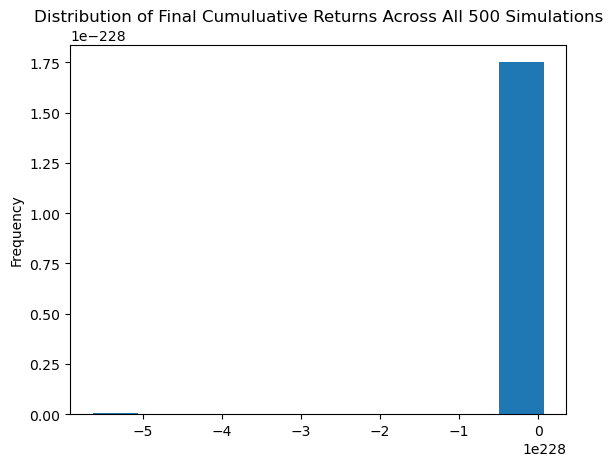

In [143]:
# Plot probability distribution and confidence intervals
mc_sim_thirtyyear.plot_distribution()

### Retirement Analysis

In [150]:
# Fetch summary statistics from the Monte Carlo simulation results
metrics = mc_sim_thirtyyear.simulated_return.iloc[-1].describe()
ci_lower = mc_sim_thirtyyear.simulated_return.iloc[-1].quantile(0.025)
ci_upper = mc_sim_thirtyyear.simulated_return.iloc[-1].quantile(0.975)
ci_series = pd.Series([ci_lower, ci_upper], index=["95% CI Lower", "95% CI Upper"])
summary = pd.concat([metrics, ci_series])

# Print summary statistics
print(summary)

count           5.000000e+02
mean           -8.800000e+08
std             9.971181e+09
min            -1.000000e+10
25%            -1.000000e+10
50%            -1.000000e+10
75%             1.000000e+10
max             1.000000e+10
95% CI Lower   -1.000000e+10
95% CI Upper    1.000000e+10
dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [151]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = ci_series["95% CI Lower"] * initial_investment
ci_upper = ci_series["95% CI Upper"] * initial_investment

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within the range of"
      f" ${ci_lower:.2f} and ${ci_upper:.2f}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within the range of $-200000000000000.00 and $200000000000000.00


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [152]:
# Set initial investment
initial_investment_2 = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower_value_2 = ci_lower * initial_investment_2
ci_upper_value_2 = ci_upper * initial_investment_2

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_2} in the portfolio"
      f" over the next 30 years will end within the range of"
      f" ${ci_lower_value_2:.2f} and ${ci_upper_value_2:.2f}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within the range of $-6000000000000000000.00 and $6000000000000000000.00


## Optional Challenge - Early Retirement


### Five Years Retirement Option

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 340.
Running Monte Carlo simulation number 350.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 360.
Running Monte Carlo simulation number 370.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 380.
Running Monte Carlo simulation number 390.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 400.
Running Monte Carlo simulation number 410.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 420.
Running Monte Carlo simulation number 430.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 440.
Running Monte Carlo simulation number 450.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 460.
Running Monte Carlo simulation number 470.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 480.
Running Monte Carlo simulation number 490.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

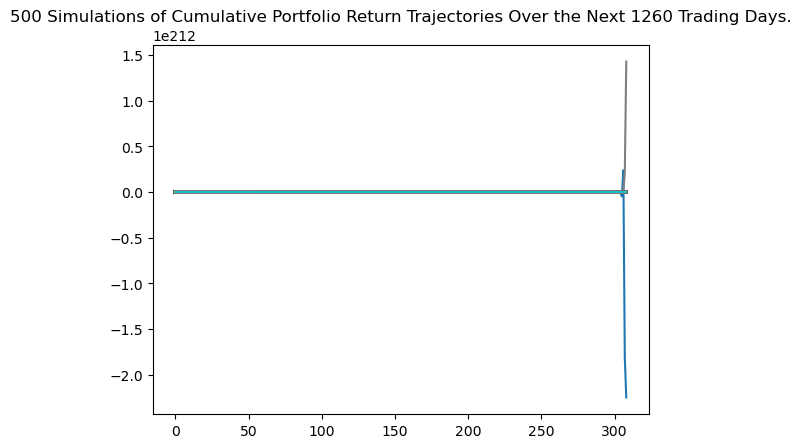

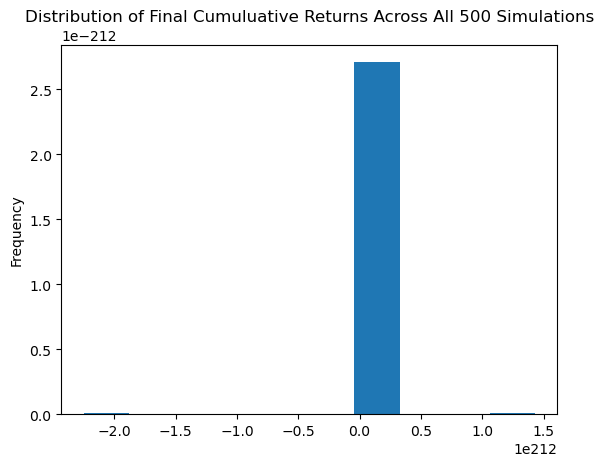

count            5.000000e+02
mean           -1.654260e+209
std                       inf
min            -2.249077e+212
25%            -6.592779e+190
50%            -1.783436e+172
75%             8.107365e+188
max             1.428782e+212
95% CI Lower   -1.128048e+204
95% CI Upper    2.633232e+203
dtype: float64
There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within the range of $-67682866793352289045172435966056835792409665346219284632282004932391773927280691479419991895075179794944475423834300669555638239634291395389788257109335848052443033319889445440594076423206968131313245664313344.00 and $15799394166330714954328746879224178376671734337743861024729373270245277782483095507515296405200898223355645919003227107193575955701668545853947580711135749661541748915642795399312570902444009574615613582606336.00


C:\Users\jiv50\anaconda3\envs\dev\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


In [153]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns

sys.path.append(r'C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code')
from MCForecastTools import MCSimulation

# Create an example DataFrame with historical prices
dates = pd.date_range(start='2020-01-01', periods=100, freq='D')
data = np.random.rand(100, 2)
historical_bars_pivot = pd.DataFrame(data, columns=['A', 'B'], index=dates)

# Add a level to the columns
historical_bars_pivot.columns = pd.MultiIndex.from_product([historical_bars_pivot.columns, ['close']])

# Calculate daily returns
close_df = historical_bars_pivot.xs('close', level=1, axis=1).pct_change().dropna()
daily_return = close_df.copy()
daily_return.columns = pd.MultiIndex.from_product([daily_return.columns, ['daily_return']])

# Combine the data
historical_bars_pivot = pd.concat([historical_bars_pivot, daily_return], axis=1)

# Parameters for 5 years
num_simulations = 500
num_trading_days = 252 * 5

# Create an instance of the MCSimulation class for 5 years
mc_sim_fiveyear = MCSimulation(
    portfolio_data=historical_bars_pivot,
    weights=[0.6, 0.4],
    num_simulation=num_simulations,
    num_trading_days=num_trading_days
)

# Run the Monte Carlo simulation for 5 years
mc_sim_fiveyear.calc_cumulative_return()

# Clean the simulated return data by removing infinite values and capping outliers
mc_sim_fiveyear.simulated_return.replace([np.inf, -np.inf], np.nan, inplace=True)
mc_sim_fiveyear.simulated_return.dropna(inplace=True)

# Plot the results
line_plot_five = mc_sim_fiveyear.plot_simulation()

# Show the plot
plt.show()

# Plot the probability distribution and confidence intervals
dist_plot_five = mc_sim_fiveyear.plot_distribution()

# Show the plot
plt.show()

# Fetch summary statistics from the Monte Carlo simulation results
metrics_five = mc_sim_fiveyear.simulated_return.iloc[-1].describe()
ci_lower_five = mc_sim_fiveyear.simulated_return.iloc[-1].quantile(0.025)
ci_upper_five = mc_sim_fiveyear.simulated_return.iloc[-1].quantile(0.975)
ci_series_five = pd.Series([ci_lower_five, ci_upper_five], index=["95% CI Lower", "95% CI Upper"])
summary_five = pd.concat([metrics_five, ci_series_five])

# Print summary statistics
print(summary_five)

# Set initial investment
initial_investment = 60000

# Use the lower and upper 95% confidence intervals to calculate the range of the possible outcomes of the $60,000 investment
ci_lower_value_five = ci_lower_five * initial_investment
ci_upper_value_five = ci_upper_five * initial_investment

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within the range of"
      f" ${ci_lower_value_five:.2f} and ${ci_upper_value_five:.2f}")

### Ten Years Retirement Option

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 110.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 120.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 130.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 140.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 150.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 160.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 170.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 180.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 190.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 200.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 230.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 240.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 250.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 260.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 270.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 280.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 290.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 300.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 310.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 320.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 330.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 340.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 350.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 360.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 370.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 380.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 390.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 400.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 410.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 420.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 430.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 440.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 450.
Running Monte Carlo simulation number 460.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 470.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 480.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 490.


C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\jiv50\anaconda3\envs\dev\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


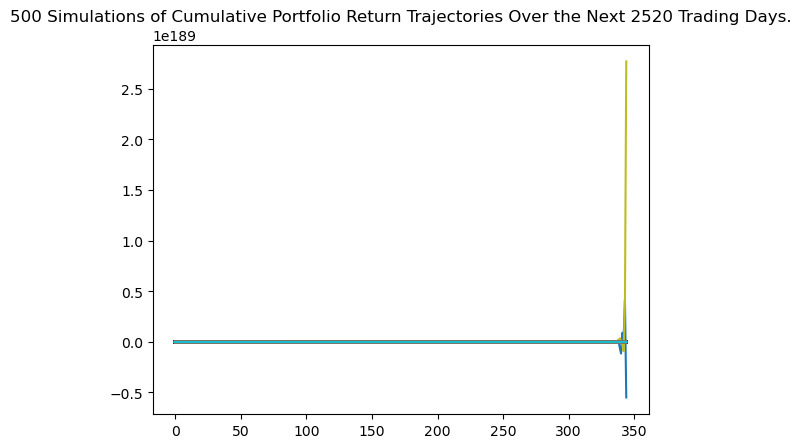

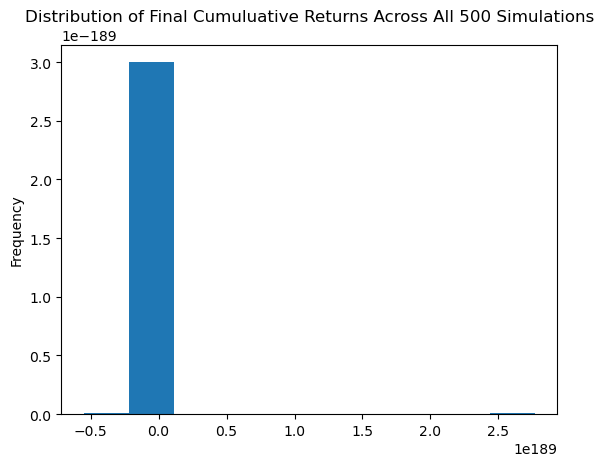

count            5.000000e+02
mean            4.441645e+186
std                       inf
min            -5.502103e+188
25%            -2.283365e+164
50%            -3.619303e+147
75%             8.321702e+164
max             2.769645e+189
95% CI Lower   -1.814826e+179
95% CI Upper    2.514525e+178
dtype: float64
There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within the range of $-10888954660382062597993653408889012835073632701808889556338120443091141685833788185008901007291361446084875908025566623095084173335577189261397336829494300559495781836566650434032238592.00 and $1508714999944208953862851092279127244529030201581179704502329820150904973825323572035381143841626488553114403057694215762148873295450313747182102832371045540052267471901661856935182336.00


C:\Users\jiv50\anaconda3\envs\dev\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


In [154]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
sys.path.append(r'C:\Users\jiv50\FinTech Working Space\05-APIs\Homework\Starter_Code')
from MCForecastTools import MCSimulation

# Create an example DataFrame with historical prices
dates = pd.date_range(start='2020-01-01', periods=100, freq='D')
data = np.random.rand(100, 2)
historical_bars_pivot = pd.DataFrame(data, columns=['A', 'B'], index=dates)

# Add a level to the columns
historical_bars_pivot.columns = pd.MultiIndex.from_product([historical_bars_pivot.columns, ['close']])

# Calculate daily returns
close_df = historical_bars_pivot.xs('close', level=1, axis=1).pct_change().dropna()
daily_return = close_df.copy()
daily_return.columns = pd.MultiIndex.from_product([daily_return.columns, ['daily_return']])

# Combine the data
historical_bars_pivot = pd.concat([historical_bars_pivot, daily_return], axis=1)

# Parameters for 10 years
num_simulations = 500
num_trading_days = 252 * 10

# Create an instance of the MCSimulation class for 10 years
mc_sim_tenyear = MCSimulation(
    portfolio_data=historical_bars_pivot,
    weights=[0.6, 0.4],
    num_simulation=num_simulations,
    num_trading_days=num_trading_days
)

# Run the Monte Carlo simulation for 10 years
mc_sim_tenyear.calc_cumulative_return()

# Clean the simulated return data by removing infinite values and capping outliers
mc_sim_tenyear.simulated_return.replace([np.inf, -np.inf], np.nan, inplace=True)
mc_sim_tenyear.simulated_return.dropna(inplace=True)

# Plot the results
line_plot_ten = mc_sim_tenyear.plot_simulation()

# Show the plot
plt.show()

# Plot the probability distribution and confidence intervals
dist_plot_ten = mc_sim_tenyear.plot_distribution()

# Show the plot
plt.show()

# Fetch summary statistics from the Monte Carlo simulation results
metrics_ten = mc_sim_tenyear.simulated_return.iloc[-1].describe()
ci_lower_ten = mc_sim_tenyear.simulated_return.iloc[-1].quantile(0.025)
ci_upper_ten = mc_sim_tenyear.simulated_return.iloc[-1].quantile(0.975)
ci_series_ten = pd.Series([ci_lower_ten, ci_upper_ten], index=["95% CI Lower", "95% CI Upper"])
summary_ten = pd.concat([metrics_ten, ci_series_ten])

# Print summary statistics
print(summary_ten)

# Set initial investment
initial_investment = 60000

# Use the lower and upper 95% confidence intervals to calculate the range of the possible outcomes of the $60,000 investment
ci_lower_value_ten = ci_lower_ten * initial_investment
ci_upper_value_ten = ci_upper_ten * initial_investment

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within the range of"
      f" ${ci_lower_value_ten:.2f} and ${ci_upper_value_ten:.2f}")

In [ ]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [ ]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")